<div>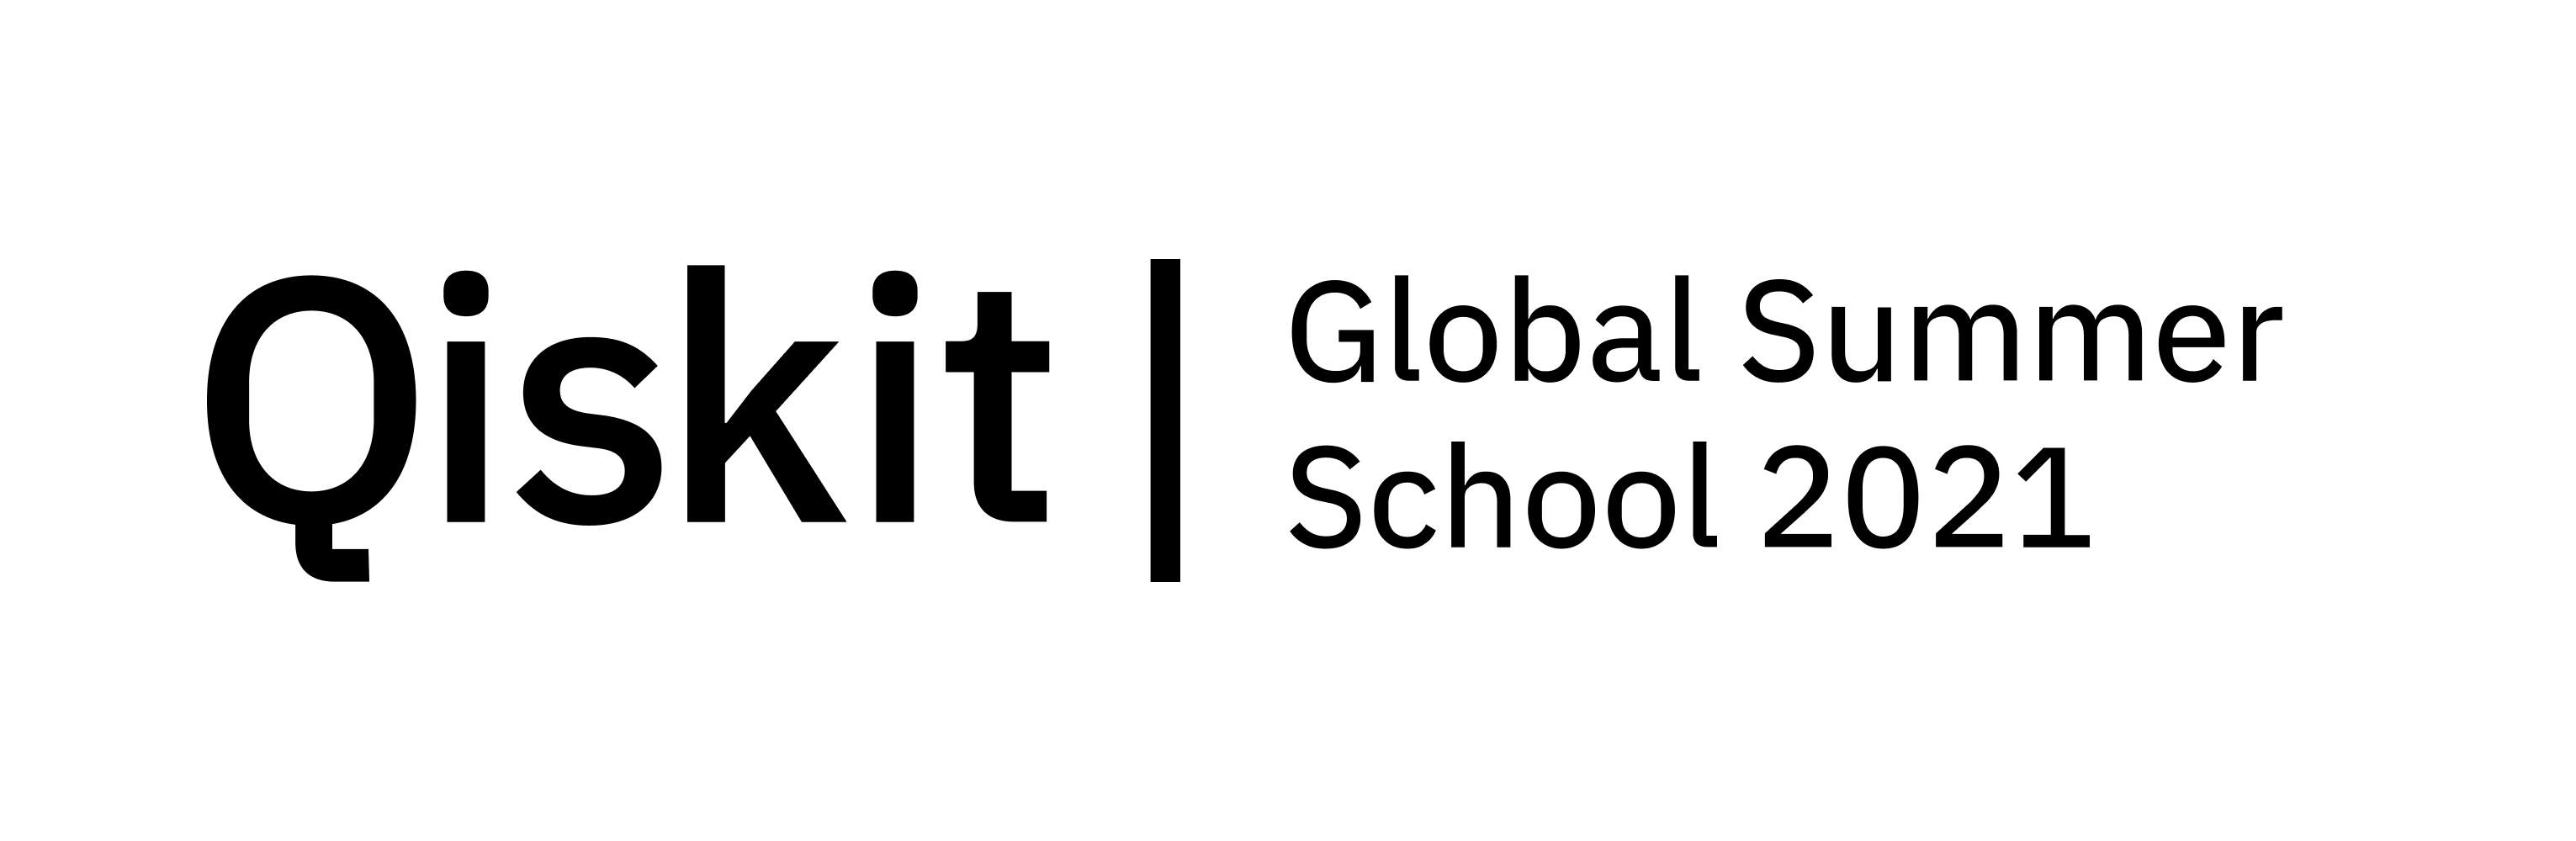</div>

# Lab 3: 量子カーネルとサポートベクターマシン

このラボでは、Qiskitに量子フィーチャーマップ、量子カーネル、量子サポートベクトル分類を実装する方法を学びます。

まずは必要なパッケージをロードしましょう。

In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

# データ

今日扱うデータは、scikit-learnで利用可能で、よく知られている手書きの [数字データセット](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset)の小さなサブセットです。 '0'と'1'の区別をつけることを目指します。

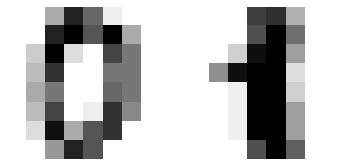

In [2]:
# 数字データセットの読み込み
digits = datasets.load_digits(n_class=2)

# '0' と'1'例のプロット
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## データ処理

このデータセットには、合計360個のデータポイントが含まれています。各データポイントは、8×8の数字の画像で、配列に折りたたまれており、各要素は0（白）から16（黒）までの整数でです。古典的な分類と同様に、データセットを学習用（100）とテスト用（20）のサンプルに分割し、正規化する必要があります。このデータセットを量子分類に用いるためには、範囲を-1から1の間にスケーリングし、次元を使用したい量子ビットの数（4）に縮小する必要があります。

Qiskitでは、[`qiskit_machine_learning.datasets.digits`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.datasets.digits.html)に含まれるこのデータセットですでに行われていますが、将来のためにこのラボでは明示的に処理を行います。

In [3]:
# データセットの分割
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# 次元削除
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 正規化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# スケーリング
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 選択
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [4]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


## データエンコード

古典的なデータを、量子特徴量マップを用いて量子状態空間にエンコードしていきます。どの特徴量マップを使用するかは重要で、分類したいデータセットに依存することがあります。ここでは、Qiskitで利用可能な特徴量マップを見て、データをエンコードするために1つを選択してカスタマイズします。

### 量子特徴量マップ

その名の通り, 量子特徴量マップ $\phi(\mathbf{x})$は古典特徴量ベクトル$\mathbf{x}$から量子状態 $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$へのマップです。ここで _n_ はエンコードに使う量子ビットの数として、このマップは初期状態$|0\rangle^{n}$上でユニタリ演算$\mathcal{U}_{\Phi(\mathbf{x})}$を適用することで実現しています。

現在Qiskitで利用可能な特徴量マップ ([`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)、 [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html) と [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)) は、[_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2)の中で紹介されているもので、特に`ZZFeatureMap` は古典的なシミュレーションが困難であり、近未来の量子デバイス上で短深度回路として実装可能であると推測されています。

`PauliFeatureMap` は次のように定義されます：


```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

深さ$d$のユニタリ演算子を記述します：

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

アダマールゲートと$d=2$の場合に以下の回路図のように古典データを符号化した量子もつれのブロック$U_{\Phi(\mathbf{x})}$を交互に入れたものを含んでいます。

<div>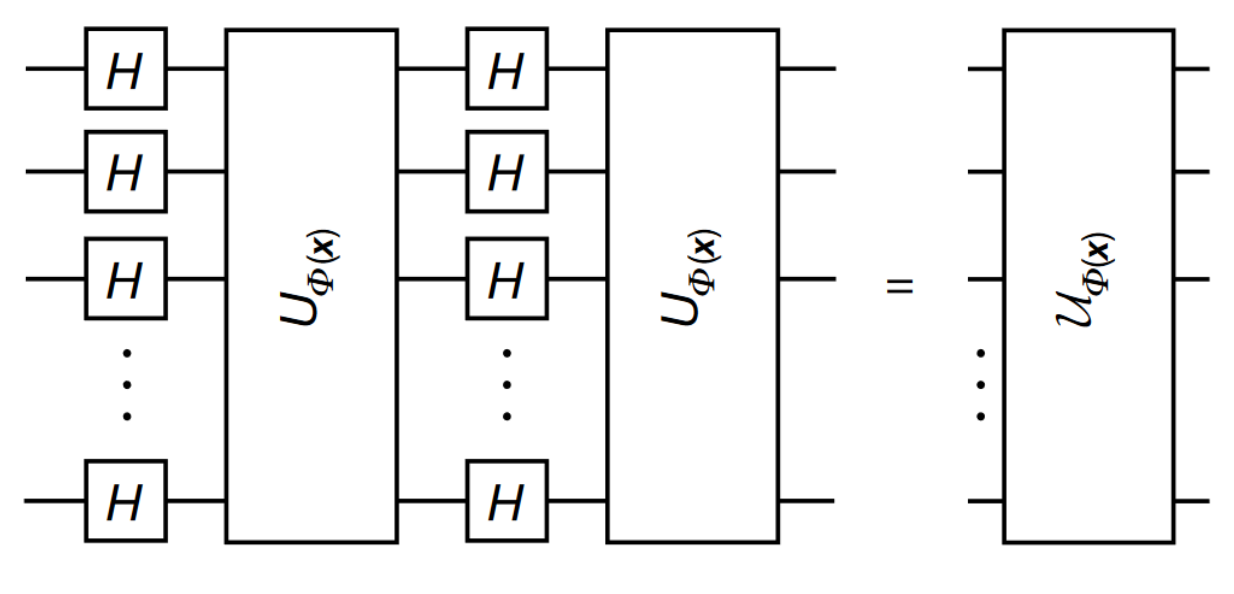</div>

量子もつれブロックの中で、 $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$はパウリ行列であり, 添字$S$は異なる量子ビットやデータ点の間を繋いでいることを示しています。: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, そして初期設定ではデータマッピング関数 $\phi_S(\mathbf{x})$は次のようになります。
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

$k = 1, P_0 = Z$のとき, これは `ZFeatureMap`です：
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

次のように定義されます：
```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

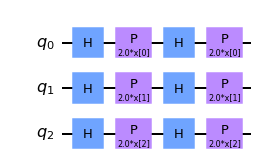

In [5]:
# 3特徴量、深さ2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.draw('mpl')

この特徴量マップにはエンタングルメントがないことから、この特徴量マップは古典的なシミュレーションが容易であり、量子的な優位性が得られないことを意味しています。

そして$k = 2, P_0 = Z, P_1 = ZZ$のとき、 これは`ZZFeatureMap`です：
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

次のように定義されます:
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

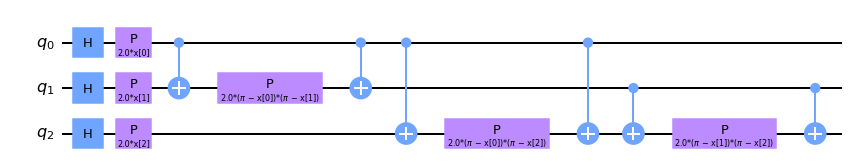

In [6]:
# 3特徴量、深さ1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.draw('mpl')

特徴量マップに量子もつれが存在することから、量子もつれマップを定義することができます。

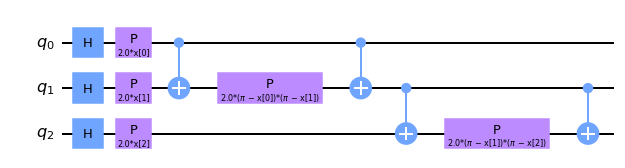

In [7]:
# 3特徴量、深さ1、線形量子もつれ
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.draw('mpl')

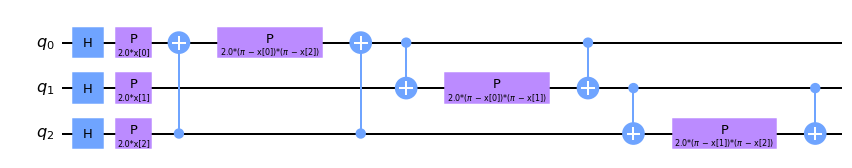

In [8]:
# 3特徴量、深さ1、巡回量子もつれ
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.draw('mpl')

特徴量マップの中のパウリゲートをカスタマイズすることができます、例えば$P_0 = X, P_1 = Y, P_2 = ZZ$：
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

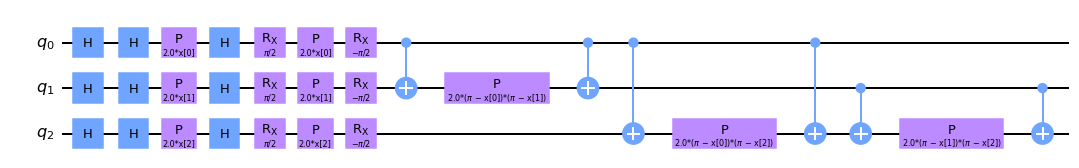

In [9]:
# 3特徴量、深さ1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.draw('mpl')

独自のデータマッピング関数を定義することができます、例えば：
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        \sin(\pi-x_i)\sin(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

In [10]:
def custom_data_map_func(x):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.sin(np.pi - x))
    return coeff

In [11]:
map_customdatamap = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)

#map_customdatamap.draw() # Qiskitでは独自データマップに含まれるnp.sinの回路を描画することはできません。 

Qiskitの回路ライブラリに含まれる[`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) と [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) 関数も特徴量マップとしてパラメーター化された量子回路を作成するために使うことができます。 

```python
TwoLocal(num_qubits=None, reps=3, rotation_blocks=None, 
         entanglement_blocks=None, entanglement='full',  
         skip_unentangled_qubits=False, 
         skip_final_rotation_layer=False, 
         parameter_prefix='θ', insert_barriers=False, 
         initial_state=None)
```

```python
NLocal(num_qubits=None, reps=1, rotation_blocks=None, 
       entanglement_blocks=None, entanglement=None,   
       skip_unentangled_qubits=False, 
       skip_final_rotation_layer=False, 
       overwrite_block_parameters=True, 
       parameter_prefix='θ', insert_barriers=False, 
       initial_state=None, name='nlocal')
```

どちらの関数も回転層と絡み合い層を交互に繰り返すパラメータ化された回路を作成します。どちらの層でも、パラメータ化された回路ブロックが、定義された方法で回路に作用します。回転層では、ブロックを重ねて適用し，エンタングルメント層では，エンタングルメント戦略に従って適用します。各層は何度か繰り返され、デフォルトでは最後に回転層が追加されます。


「NLocal」では、回路ブロックは任意の大きさ（回路内の量子ビット数以下）を持つことができ、「TwoLocal」では、回転層はすべての量子ビットに適用される単一量子ビットゲートであり、エンタングルメント層は2量子ビットゲートを使用します。

例えば、これは回転層に$R_y$と $R_z$を使い、量子もつれ層には巡回量子もつれを使った `TwoLocal`回路です。

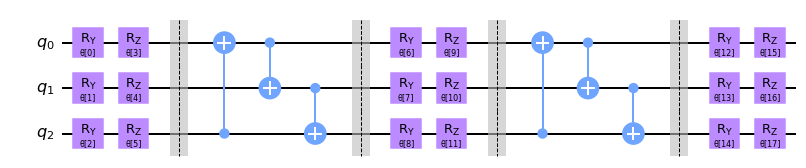

In [12]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.draw('mpl')

そして同等の`NLocal`回路です：

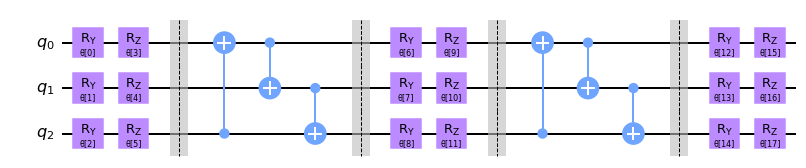

In [13]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.draw('mpl')

これは別の`NLocal`回路で、２量子ビット間での回転ブロックと、線形量子もつれを使った４量子ビットの量子もつれ層を使っています：

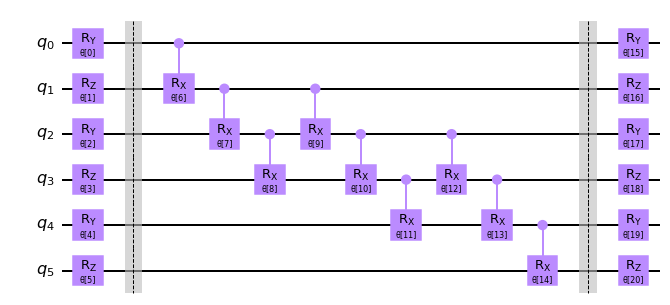

In [14]:
# 回転層：
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# 量子もつれ層：
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

nlocal = NLocal(num_qubits=6, rotation_blocks=rot, entanglement_blocks=ent, 
                entanglement='linear', insert_barriers=True)
nlocal.draw('mpl')

また、完全にカスタマイズされたパラメータ付きの回路特徴量マップを作成することも可能です。 そうするために、 単純に [`ParameterVector`](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html)で`QuantumCircuit`を作ります。  こちらが例です：

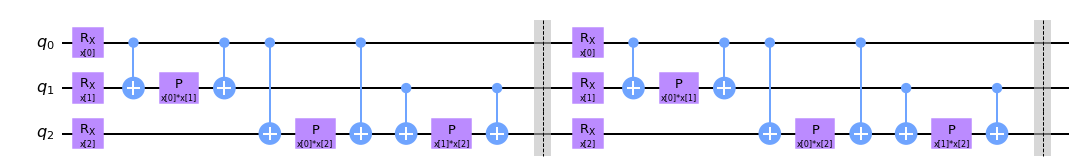

In [15]:
qubits = 3     
repeats = 2

x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)

for _ in range(repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            var_custom.cx(i, j)
            var_custom.p(x[i] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()
            
var_custom.draw('mpl')

`ZZFeatureMap`を使っている最初の学習用サンプルをエンコードしてみましょう：

In [16]:
print(sample_train[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]


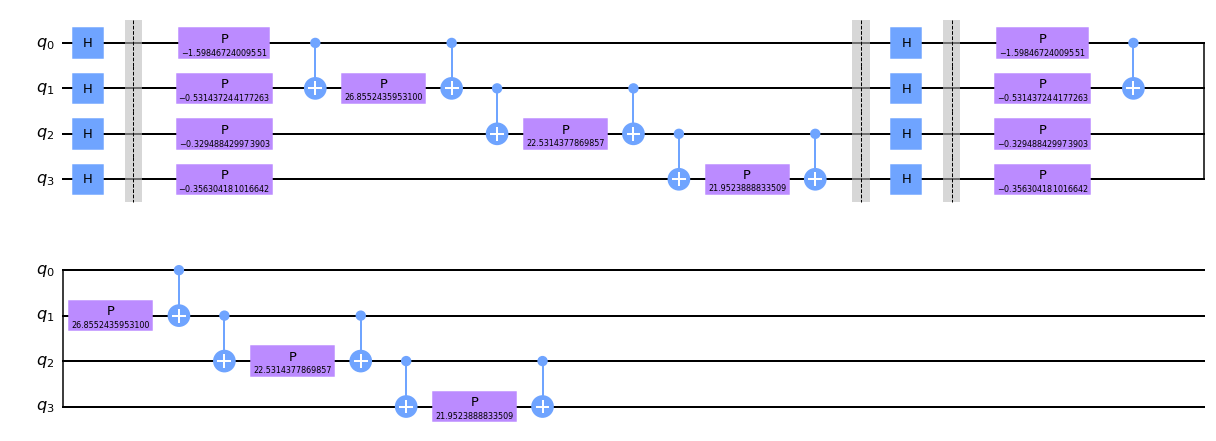

In [17]:
encode_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.draw(output='mpl')

<div class="alert alert-block alert-success">

### Exercise 1: データエンコード
    
４回の繰り返しを持つ`ZZFeatureMap` と初期データマッピング関数を使って、データ点$x = (-0.1,0.2)$をエンコードしてみましょう。

</div>

In [ ]:
x = [-0.1,0.2]

# ここにコードを書いてください。

In [ ]:
from qc_grader import grade_lab3_ex1

# grade関数は量子回路を期待していることに注意してください
grade_lab3_ex1(ex1_circuit)

## 量子カーネル推定

量子特徴量マップ$\phi(\mathbf{x})$は自然に類似度（$\mathbf{x}_i$ と $\mathbf{x}_j$が近くなると$k(\mathbf{x}_i,\mathbf{x}_j)$が大きくなる）の測定に見えるような量子カーネル$k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$を生じさせます。

有限のデータを考える場合、量子カーネルを行列で表すことができます：
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$

このカーネル行列の各要素を量子コンピュータ上で計算することで、遷移の振幅を算出することができます。
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$

特徴量マップがパラメータ化された量子回路であると仮定すると、それは$n$量子ビットのユニタリー変換$\mathbf{U_\phi}(\mathbf{x})$として記述することができます。

これにより、量子カーネル行列の推定値が得られ、サポートベクトル分類などのカーネル機械学習アルゴリズムに使用することができます。

[*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2)で議論されているように、量子カーネルマシンアルゴリズムは、対応する量子カーネルを古典的に推定するのが難しい場合にのみ、古典的なアプローチに対して量子的な優位性を発揮する可能性があります。

後述するように、古典的な資源を用いてカーネルを推定することの難しさは、もちろん、量子的な優位性を得るための必要条件に過ぎず、必ずしも十分条件ではありません。

しかしながら、 最近では [*Liu et al.* arXiv:2010.02174 (2020)](https://arxiv.org/abs/2010.02174)の中で、量子カーネル法を利用した学習者が古典的な学習者よりも量子的に有利な学習問題が存在する、ということが証明されています。

学習データとテストデータの準備ができたので、[ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)を使って`QuantumKernel`クラスを設定します。 そして`BasicAer`の`statevector_simulator`を使って学習とテストのカーネル行列を推定します。

In [18]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

学習用カーネル行列の要素の1つである、第1学習用データサンプルと第2学習用データサンプルの間の遷移振幅を計算してみましょう。

In [19]:
print(sample_train[0])
print(sample_train[1])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


最初に回路を作り描画してみます：

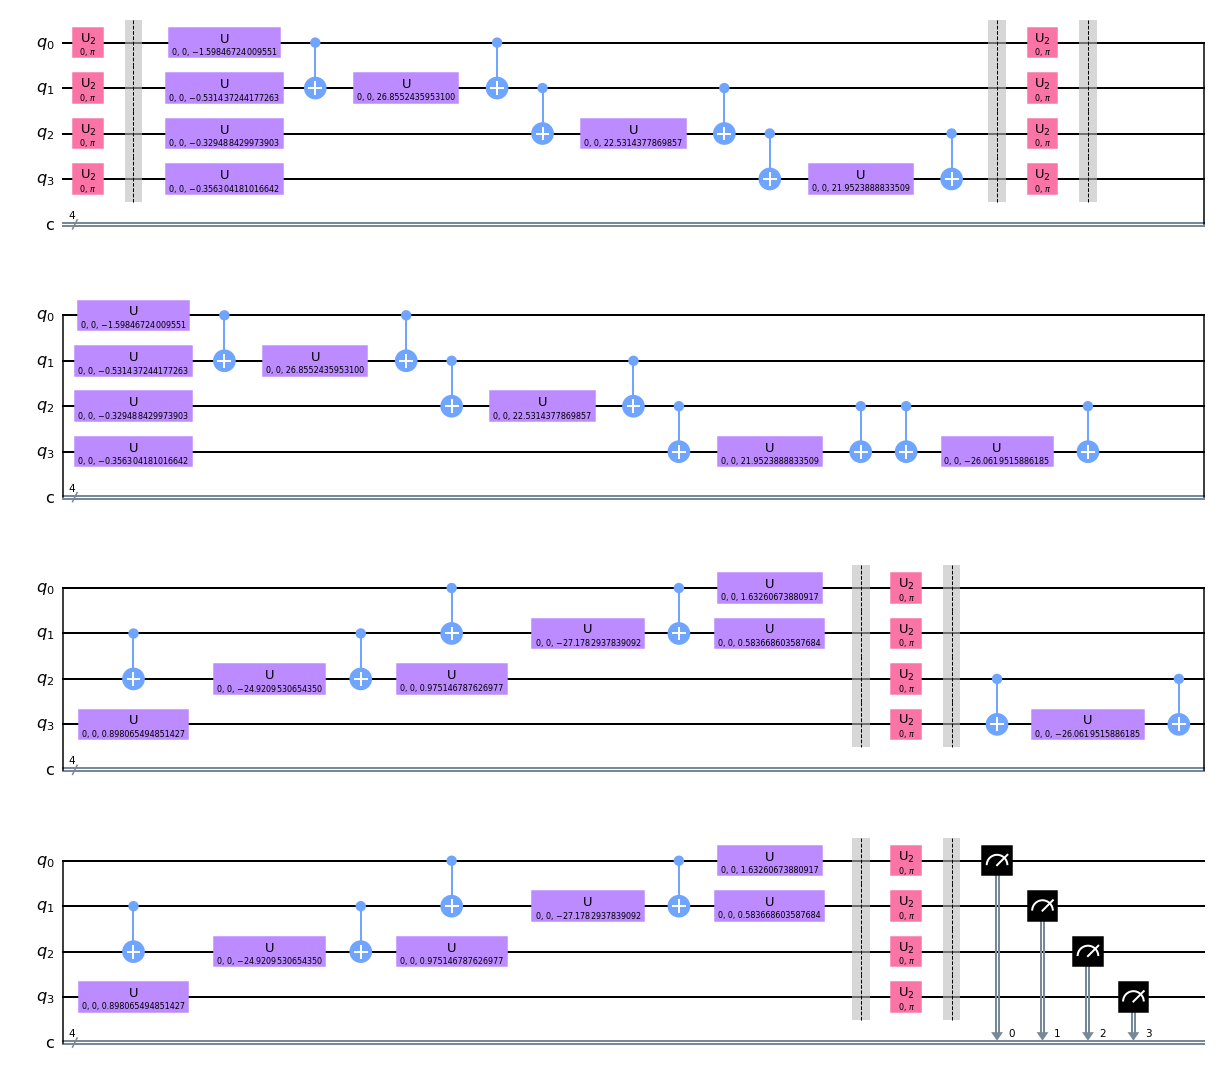

In [20]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

ゲートのパラメータは少し読みにくいですが、回路が対称になっていることに注目してください。一方の半分はデータサンプルの一方を、もう一方の半分はもう一方をコード化しています。

次に回路のシミュレーションを行います。回路には計測値が含まれているので、`qasm_simulator`を使用しますが、サンプリングノイズの影響を減らすために、ショット数を増やします。

In [21]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

遷移の振幅は、ゼロ状態のカウント数の割合です：

In [22]:
counts['0000']/sum(counts.values())

0.001953125

このプロセスを，学習データサンプルのペアごとに繰り返して学習カーネル行列を埋め，学習データサンプルとテストデータサンプルの間で繰り返してテストカーネル行列を埋めていきます。なお，各行列は対称形であるため，計算時間を短縮するために，エントリの半分だけを明示的に計算します。

ここでは、学習とテストのカーネル行列を計算し、プロットします。

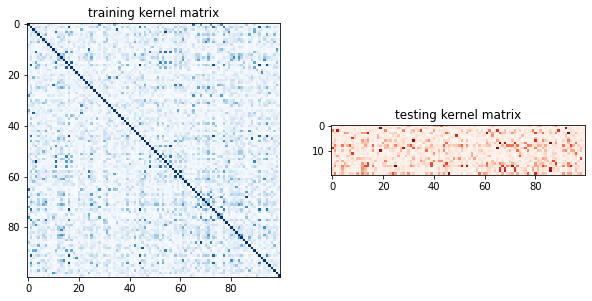

In [23]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

<div class="alert alert-block alert-success">

### Exercise 2: 量子カーネル

４回の繰り返しを持つ`ZZFeatureMap`と、初期データマッピング関数を使って$x=(−0.1,0.2)$と$y=(0.4,-0.6)$の間の遷移確率を計算してください。`shots = 8192`、 `seed_simulator = 1024` と `seed_transpiler = 1024`として`qasm_simulator`を使ってください。

</div>

In [ ]:
x = [-0.1,0.2]
y = [0.4,-0.6]

# ここにコードを書いてください

In [ ]:
from qc_grader import grade_lab3_ex2

# grade関数は浮動小数点を期待していることに注意してください
grade_lab3_ex2(amplitude)

## 量子サポートベクター分類

 [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2)で紹介されてりるように、量子サポートベクター分類は、以下のステップで構成されています：

<div>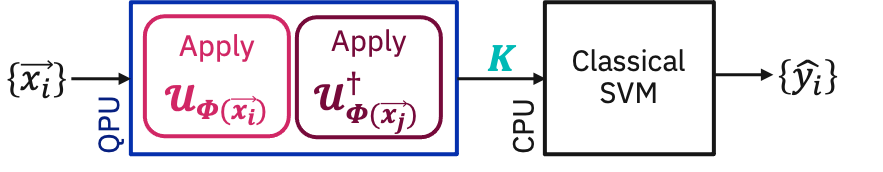</div> 

1. 学習とテストの量子カーネル行列を構築します
    1. 学習用データ点の各ペア $\mathbf{x}_{i},\mathbf{x}_j$に対して、 特徴量マップの適用と遷移確率の測定をします： $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. 各学習用データ点 $\mathbf{x_i}$とテスト用データ点 $\mathbf{y_i}$に対して、 特徴量マップの適用と遷移確率の測定をします： $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. 古典的なサポートベクターマシン分類アルゴリズムにおいて，学習用およびテスト用の量子カーネル行列を使用します。

`scikit-learn` `svc`アルゴリズムによって、２つの方法で [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) を定義することができるようになります： カーネルを呼び出し可能な関数として提供したり、カーネル行列を事前に計算したりすることができます。Qiskitの`QuantumKernel`クラスを使って、これらのいずれかを行うことができます。

以下のコードは，先に計算した学習用とテスト用のカーネル行列を受け取り，`scikit-learn`の`svc`アルゴリズムに提供しています：

In [24]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.95


以下のコードでは、カーネルを呼び出し可能な関数として提供しています：

In [25]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.95


これは、量子カーネルを様々な古典カーネルと簡単に比較することができるので便利です：

In [26]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  0.95
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  1.00


### Exploration: 量子サポートベクター分類

異なるQiskit [feature maps](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits)と[datasets](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.datasets.html)を使ってQuantum Support Vector Classificationを実行してみてください。 